In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aryanshelke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aryanshelke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Load the LIAR dataset
df = pd.read_csv('datasets/liar/train.tsv', sep='\t', header=None)
df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Map labels to binary classification
label_map = {
    'true': 1,
    'mostly-true': 1,
    'half-true': 1,
    'barely-true': 0,
    'false': 0,
    'pants-fire': 0
}
df['label'] = df['label'].map(label_map)

# Keep only the statement and label columns
df = df[['statement', 'label']]
print("Dataset shape:", df.shape)

Dataset shape: (10240, 2)


In [4]:
# Text preprocessing function
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize and remove stopwords
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(words)

# Apply preprocessing to statement column
df['statement'] = df['statement'].apply(preprocess_text)

# Tokenization parameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200

# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df['statement'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['statement'])

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['label'], 
                                                    test_size=0.2, random_state=42)

# Print shapes to verify
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (8192, 200)
Testing data shape: (2048, 200)


Epoch 1/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 51s 227ms/step - accuracy: 0.4785 - loss: 1.1163 - val_accuracy: 0.4210 - val_loss: 1.0906 - learning_rate: 5.0000e-05
Epoch 2/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 51s 247ms/step - accuracy: 0.4873 - loss: 1.0819 - val_accuracy: 0.4228 - val_loss: 1.0569 - learning_rate: 5.0000e-05
Epoch 3/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 55s 269ms/step - accuracy: 0.4905 - loss: 1.0521 - val_accuracy: 0.5119 - val_loss: 1.0260 - learning_rate: 5.0000e-05
Epoch 4/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 53s 259ms/step - accuracy: 0.5127 - loss: 1.0192 - val_accuracy: 0.5387 - val_loss: 0.9978 - learning_rate: 5.0000e-05
Epoch 5/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 50s 243ms/step - accuracy: 0.5031 - loss: 0.9924 - val_accuracy: 0.5034 - val_loss: 0.9721 - learning_rate: 5.0000e-05
Epoch 6/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 54s 262ms/step - accuracy: 0.5000 - loss: 0.9660 - val_accuracy: 0.5333 - val_loss: 0.9478 - learning_rate: 5.0000e-05
Epoch 7/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 51s 24

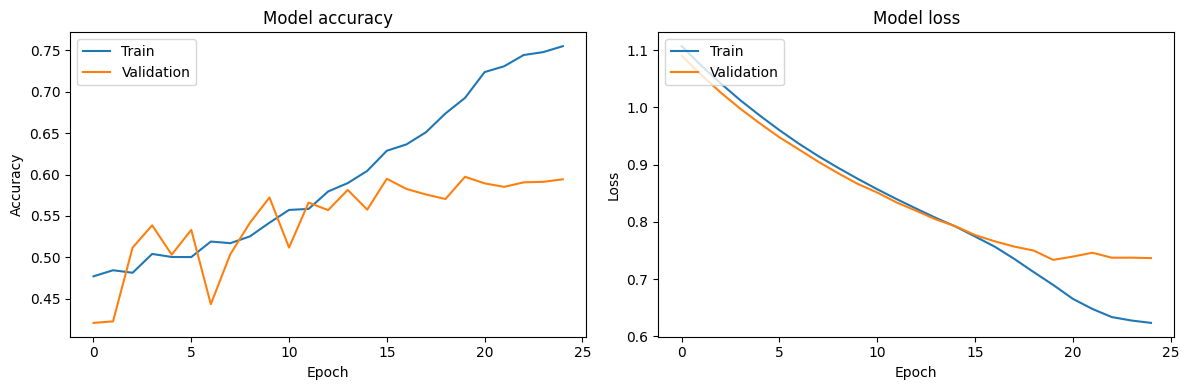

In [8]:
# Model parameters
EMBEDDING_DIM = 50  # Reduced from 100
vocab_size = len(tokenizer.word_index) + 1

# Create the model with reduced complexity
model = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(32, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)),  # Reduced units, increased dropout
    Bidirectional(LSTM(16, dropout=0.4, recurrent_dropout=0.4)),  # Reduced units, increased dropout
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),  # Increased L2 regularization
    Dropout(0.6),  # Increased dropout
    Dense(1, activation='sigmoid')
])

# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Compile the model with an even lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)  # Reduced learning rate
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Add early stopping with more patience
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Increased patience
    restore_best_weights=True
)

# Add learning rate reduction
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.00001
)

# Train the model with validation split and class weights
history = model.fit(
    X_train, y_train,
    epochs=30,  # Increased epochs since we have early stopping
    batch_size=32,  # Reduced batch size
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,  # Added class weights
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [1]:
import pickle

# Save the model
with open('models/Liar/BiLSTM_Liar_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the tokenizer
with open('models/Liar/BiLSTM_Liar_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

FileNotFoundError: [Errno 2] No such file or directory: 'models/Liar/BiLSTM_Liar_model.pkl'